In [ ]:
import db_management
import db_manipulation as db
import time

db_management.manage()

## Data Extraction

In [ ]:
import extract_basic_institution_info
import find_events_page
import extract_article_urls
import extract_VIZ_webpage_article_texts
import threading
import extract_24_ur_posts
import extract_rtv_slo_posts
import determine_school_mention

In [ ]:
# Extract institution's type, name, website and municipality
extract_basic_institution_info.extract_information()

In [ ]:
# Extract the institution's events page
vzgojno_izobrazevalni_zavodi = db.get_all_vzgojno_izobrazevalni_zavodi()

for zavod in vzgojno_izobrazevalni_zavodi:
    print(zavod["name"])
    check = db.get_events_page_url(zavod["id"])
    if check and check.strip():
        print("    Already saved ⏩")
        continue

    for i in range(3): # Attempt 3 times in case of error
        try:
            if zavod["website"]:
                events_page_url = find_events_page.find_events_page(zavod["website"])
            else:
                events_page_url = ""
            
            print(f"    Attempt {i+1}: ✅")
            break

        except Exception as e:
            events_page_url = ""
            print(f"    Attempt {i+1}: ❌")
            with open("logs.txt", "a") as f:
                f.write(zavod["name"]+"\n"+zavod["website"]+"\n"+str(e)+"\n\n\n\n")

        time.sleep(3)

    db.add_events_page_url(zavod["id"], events_page_url)

In [ ]:
extract_article_urls.extract_article_urls()

In [ ]:
viz_webpage_threads:list[threading.Thread] = []
length = len(db.get_all_vzgojno_izobrazevalni_zavodi())
workers = 20
chunk_size = int(length/workers)
for i in range(workers):
    start_indx = i*chunk_size
    end_indx = i*chunk_size + chunk_size

    # Add the remainder to the last worker
    if i == workers-1:
        end_indx += length - end_indx

    t = threading.Thread(target=extract_VIZ_webpage_article_texts.extract_texts, kwargs={"start_indx":start_indx, "end_indx":end_indx}, daemon=True)
    viz_webpage_threads.append(t)

for t in viz_webpage_threads:
    t.start()

for t in viz_webpage_threads:
    t.join()

In [ ]:
media_24_ur_threads:list[threading.Thread] = []
length = len(db.get_all_vzgojno_izobrazevalni_zavodi())
workers = 5
chunk_size = int(length/workers)
for i in range(workers):
    start_indx = i*chunk_size
    end_indx = i*chunk_size + chunk_size

    # Add the remainder to the last worker
    if i == workers-1:
        end_indx += length - end_indx

    t = threading.Thread(target=extract_24_ur_posts.extract, kwargs={"start_indx":start_indx, "end_indx":end_indx}, daemon=True)
    media_24_ur_threads.append(t)

for t in media_24_ur_threads:
    t.start()

for t in media_24_ur_threads:
    t.join()

In [ ]:
media_rtv_slo_threads:list[threading.Thread] = []
length = len(db.get_all_vzgojno_izobrazevalni_zavodi())
workers = 5
chunk_size = int(length/workers)
for i in range(workers):
    start_indx = i*chunk_size
    end_indx = i*chunk_size + chunk_size

    # Add the remainder to the last worker
    if i == workers-1:
        end_indx += length - end_indx

    t = threading.Thread(target=extract_rtv_slo_posts.extract, kwargs={"start_indx":start_indx, "end_indx":end_indx}, daemon=True)
    media_rtv_slo_threads.append(t)

for t in media_rtv_slo_threads:
    t.start()

for t in media_rtv_slo_threads:
    t.join()

In [ ]:
determine_school_mention_threads:list[threading.Thread] = []
length = len(db.get_all_media_article_candidates())
workers = 15
chunk_size = int(length/workers)
for i in range(workers):
    start_indx = i*chunk_size
    end_indx = i*chunk_size + chunk_size

    # Add the remainder to the last worker
    if i == workers-1:
        end_indx += length - end_indx

    t = threading.Thread(target=determine_school_mention.determine, kwargs={"start_indx":start_indx, "end_indx":end_indx}, daemon=True)
    determine_school_mention_threads.append(t)

for t in determine_school_mention_threads:
    t.start()

for t in determine_school_mention_threads:
    t.join()

## Sentiment Analisys

In [ ]:
import sentiment_analysis

In [ ]:
vizs = db.get_all_vzgojno_izobrazevalni_zavodi()

for viz in vizs:
    print(viz["name"])

    website_articles = db.get_webpage_articles_by_viz_id(viz["id"])
    media_articles = db.get_media_articles_by_viz_id(viz["id"])

    website_article_scores:list[int|float] = []
    media_article_scores:list[int|float] = []

    for article in website_articles:
        website_article_scores.append( sentiment_analysis.get_sentiment(article["content"]) )
    for article in media_articles:
        media_article_scores.append( sentiment_analysis.get_sentiment(article["content"]) )
    
    website_articles_avg_score = sum(website_article_scores) / len(website_article_scores) if website_article_scores else None
    media_articles_avg_score = sum(media_article_scores) / len(media_article_scores) if media_article_scores else None

    avg_sources = []
    if website_article_scores: avg_sources.append(website_articles_avg_score)
    if media_article_scores: avg_sources.append(media_articles_avg_score)

    if avg_sources == []:
        avg_score = None
    else:
        avg_score = sum(avg_sources) / len(avg_sources)

    db.add_sentiment_by_viz_datapoint(viz["id"], website_articles_avg_score, media_articles_avg_score, avg_score)
    print(f"    Website: {website_articles_avg_score}   Media: {media_articles_avg_score}   Combined: {avg_score}")

# Visualisation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Število pozitivno, nevtralno in negativno ocenjenih VIZ
positive = 0
negative = 0
neutral = 0

for datapoint in db.get_sentiment_by_viz_datapoints():
    avg = datapoint["average_sentiment"]
    if not avg: continue

    if avg > 70: positive += 1
    elif avg < 30: negative += 1
    else: neutral += 1

plt.bar(["pozitivno", "nevtralno", "negativno"], [positive, negative, neutral])

In [ ]:
# Ocene po občini
vizs = db.get_all_vzgojno_izobrazevalni_zavodi()
municipalities = set()

for viz in vizs:
    if viz["municipality"] not in municipalities:
        municipalities.add(viz["municipality"])

average_score_by_municipality = {}
for municipality in municipalities:
    vizs_by_m = db.get_vzgojno_izobrazevalni_zavodi_by_municipality(municipality)
    average_sources = []

    for viz in vizs_by_m:
        avg = db.get_sentiment_datapoint_by_viz_id(viz["id"])["average_sentiment"]
        if avg is not None: average_sources.append(float(avg))

    if average_sources:
        average_score_by_municipality[municipality] = sum(average_sources) / len(average_sources)
    else:
        average_score_by_municipality[municipality] = np.nan

#x = sorted(list(average_score_by_municipality.keys()), key=lambda item: average_score_by_municipality[item])
x = sorted(
    average_score_by_municipality,
    key=lambda m: (np.isnan(average_score_by_municipality[m]),
                   average_score_by_municipality[m])
)
y = [average_score_by_municipality[key] for key in x]

plt.figure(figsize=(25, 6))
plt.bar(x, y)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

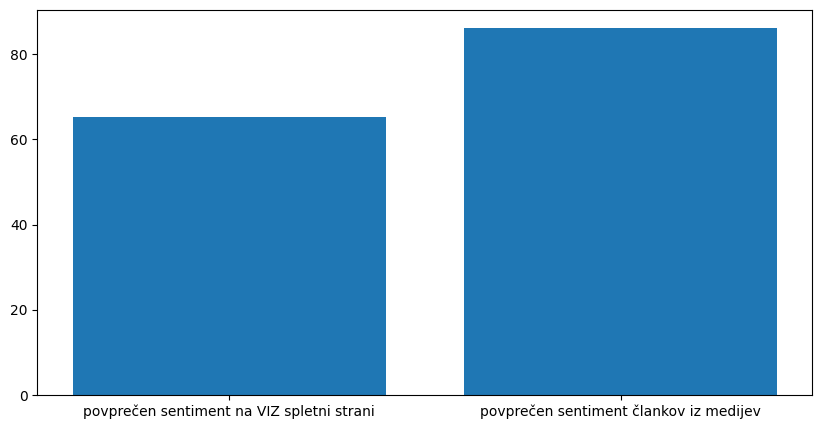

In [26]:
# Razlika med sentimentom na spletni strani in medijih
average_website_sources = []
average_media_sources = []

for datapoint in db.get_sentiment_by_viz_datapoints():
    if datapoint["media_sentiment"] is not None: average_website_sources.append(datapoint["media_sentiment"])
    if datapoint["website_sentiment"] is not None: average_media_sources.append(datapoint["website_sentiment"])

average_website_score = sum(average_website_sources) / len(average_website_sources)
average_media_score = sum(average_media_sources) / len(average_media_sources)

plt.figure(figsize=(10, 5))
plt.bar(["povprečen sentiment na VIZ spletni strani", "povprečen sentiment člankov iz medijev"], [average_website_score, average_media_score])
plt.show()